In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical


In [17]:

train_x = np.load(r"C:\Users\PC\Downloads\cnn-face-recognition-25\faces_train_x.npz")["arr_0"]
train_y = pd.read_csv(r"C:\Users\PC\Downloads\cnn-face-recognition-25\faces_train_y.csv")["Predicted"]
test_x = np.load(r"C:\Users\PC\Downloads\cnn-face-recognition-25\faces_test_x.npz")["arr_0"]
sample_submission = pd.read_csv(r"C:\Users\PC\Downloads\cnn-face-recognition-25\faces_test_sample_solution.csv")


In [18]:
# Check if any NaNs in training features
print("Missing values in train_x:", np.isnan(train_x).sum())

# Check for missing labels
print("Missing values in train_y:", train_y.isna().sum())


Missing values in train_x: 0
Missing values in train_y: 0


In [19]:
# Find duplicate rows
duplicates = np.unique(train_x, axis=0, return_counts=True)[1]
print("Number of duplicate images:", np.sum(duplicates > 1))


Number of duplicate images: 0


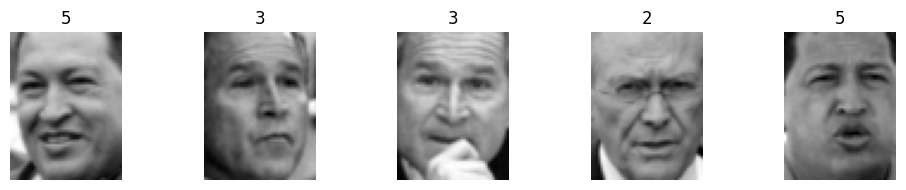

In [20]:
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_x[i], cmap='gray')
    plt.title(f"{train_y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import train_test_split

# Flatten the image data
train_x_flat = train_x.reshape(train_x.shape[0], -1).astype('float32') / 255.0
test_x_flat = test_x.reshape(test_x.shape[0], -1).astype('float32') / 255.0

# Split into training and validation (80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(train_x_flat, train_y, test_size=0.2, random_state=42)


In [22]:
from sklearn.decomposition import PCA

# Fit PCA on training data and transform both train and validation
pca = PCA(n_components=100, random_state=42)
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)
test_x_pca = pca.transform(test_x_flat)


In [23]:
#Train SVM on PCA-transformed training data
for kernel in ['linear', 'rbf', 'poly']:
    print(f"\n Training SVM with kernel = {kernel}")
    model = SVC(kernel=kernel, random_state=42)
    model.fit(x_train_pca, y_train)
    preds = model.predict(x_val_pca)
    score = f1_score(y_val, preds, average='micro')
    print(f"Micro F1 Score ({kernel}):", score)



 Training SVM with kernel = linear
Micro F1 Score (linear): 0.815

 Training SVM with kernel = rbf
Micro F1 Score (rbf): 0.67

 Training SVM with kernel = poly
Micro F1 Score (poly): 0.475


In [25]:
final_svm_model = SVC(kernel='linear', random_state=42)
final_svm_model.fit(x_train_pca, y_train)

val_preds_svm = final_svm_model.predict(x_val_pca)
train_preds_svm = final_svm_model.predict(x_train_pca)

print("\nFinal SVM Model Performance:")
print("Training Accuracy:", accuracy_score(y_train, train_preds_svm))
print("Validation Accuracy:", accuracy_score(y_val, val_preds_svm))
print("Training F1 Score:", f1_score(y_train, train_preds_svm, average='micro'))
print("Validation F1 Score:", f1_score(y_val, val_preds_svm, average='micro'))



Final SVM Model Performance:
Training Accuracy: 0.99375
Validation Accuracy: 0.815
Training F1 Score: 0.99375
Validation F1 Score: 0.815


In [26]:
#Prepare data for CNN
train_x_cnn = train_x.astype('float32') / 255.0
test_x_cnn = test_x.astype('float32') / 255.0

train_x_cnn = train_x_cnn[..., np.newaxis]
test_x_cnn = test_x_cnn[..., np.newaxis]

num_classes = len(np.unique(train_y))
train_y_cat = to_categorical(train_y, num_classes)



In [27]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(62, 47, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train and save history
history = cnn_model.fit(
    train_x_cnn,
    train_y_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.3571 - loss: 1.8546 - val_accuracy: 0.4100 - val_loss: 1.7648
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.4004 - loss: 1.7350 - val_accuracy: 0.5150 - val_loss: 1.6598
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.4773 - loss: 1.5298 - val_accuracy: 0.4950 - val_loss: 1.4839
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.6209 - loss: 1.1643 - val_accuracy: 0.6400 - val_loss: 1.1216
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 0.6897 - loss: 0.9407 - val_accuracy: 0.7400 - val_loss: 0.8547
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.8262 - loss: 0.5850 - val_accuracy: 0.7050 - val_loss: 0.8001
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8625 - loss: 0.4766 - val_accuracy: 0.8000 - val_loss: 0.6429
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8872 - loss: 0.3287 - val_accuracy: 0.

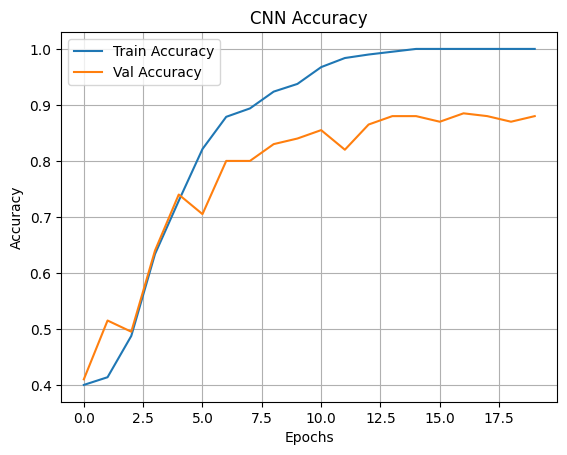

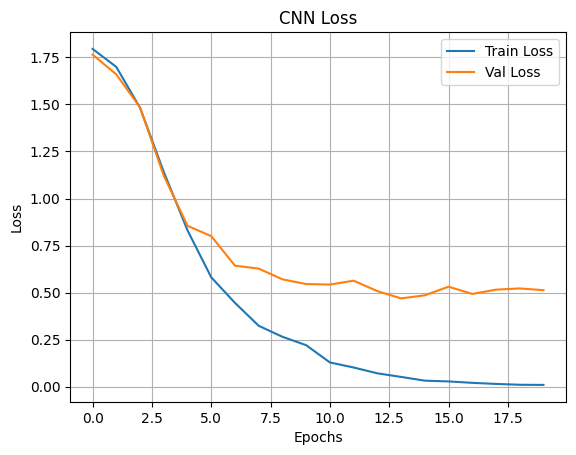

In [28]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Final validation evaluation for CNN
val_loss, val_acc = history.history['val_loss'][-1], history.history['val_accuracy'][-1]

print("\n CNN vs SVM Validation Accuracy:")
print(f"SVM Validation Accuracy: {accuracy_score(y_val, val_preds_svm):.4f}")
print(f"CNN Validation Accuracy: {val_acc:.4f}")



 CNN vs SVM Validation Accuracy:
SVM Validation Accuracy: 0.8150
CNN Validation Accuracy: 0.8800
